In [209]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import sqlalchemy as db
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *

np.seterr(divide = 'ignore')
pd.set_option('display.max_rows', 500)

In [210]:
# load_dotenv()

# # config and credentials
# server = os.getenv('server')
# database = os.getenv('database')
# username = os.getenv('username')
# password = os.getenv('password')

# # connection
# engine = db.create_engine(
#     'mssql://{}:{}@{}/{}?driver=ODBC+Driver+18+for+SQL+Server'.format(
#         username, password, server, database
#     )
# )

# # establish connection
# connection = engine.connect()

In [211]:
def get_sample_particulars(df):
    print('Number of observations: {:,}'.format(len(df.index)))
    print('Returns: Mean: {:.5f} | Median: {:.5f} | Std returns: {:.5f}'.format(
        100 * df['R'].mean(), 100 * df['R'].median(), df['R'].std()))
    print('Volume mean: {:.5f}'.format(df['Volume'].mean()))
    print('Coupon mean: {:.5f}'.format(df['Coupon'].mean()))

### Query Selection

In [212]:
# query_top = '''
#     SELECT
#         CusipId,
#         TrdExctnDtEOM,
#         Coupon,
#         RatingClass,
#         MaturityBand,
#         Volume,
#         R
#     FROM
#         BondReturns_lastFive_nonTopBonds
#     ORDER BY
#         CusipId,
#         TrdExctnDtEOM
# '''

# # read sql
# df = pd.read_sql(query_top, connection)
# df.to_csv('data/output/momentum/mom-lastFive-nonTopBonds.csv', index=False)

In [213]:
# read csv
df = pd.read_csv(
    'data/output/momentum/mom-lastFive-nonTopBonds.csv', 
    dtype={
        'CusipId': 'string',
        'TrdExctnDtEOM': 'string',
        'Coupon': 'float64',
        'RatingClass': 'string',
        'MaturityBand': 'string',
        'Volume': 'float64',
        'R': 'float64'
    },
    parse_dates=['TrdExctnDtEOM']
)

df.columns = ['Cusip', 'Date', 'Coupon', 'RatingClass', 'MaturityBand', 'Volume', 'R']

### Quantile Filtering and Outlier Visualization

In [214]:
df['quantiles'] = pd.qcut(df.R, np.linspace(0, 1, 201), labels=np.linspace(0, 1, 200)).astype(float)
df['outliers'] = np.where((df['quantiles'] > 0.995) | (df['quantiles'] < 0.005), 1, 0)
df['Year'] = df['Date'].dt.year

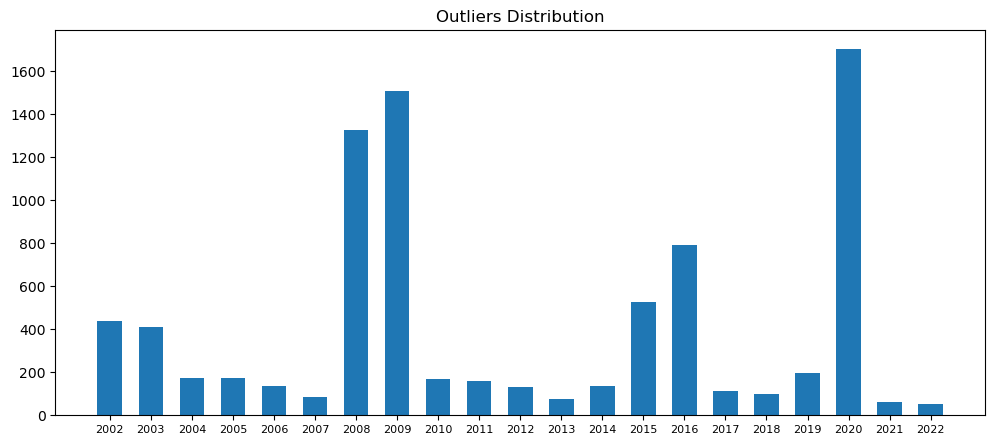

In [215]:
df_g = df.groupby('Year')['outliers'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.title('Outliers Distribution')
plt.bar(df_g['Year'], df_g['outliers'], width = 0.6)
plt.xticks([i for i in range(2002, 2023)], fontsize=8)
plt.show()

In [216]:
# filter out outliers
df['R'] = np.where(df['outliers'] == 0, df['R'], np.nan)

### Exploratory Analysis

In [217]:
df['Cusip'].nunique()

23248

In [218]:
# number of entries
df['RatingClass'].value_counts()

HY    821659
IG    183945
Name: RatingClass, dtype: Int64

In [219]:
# number of distinct Cusips
df.groupby('RatingClass').Cusip.nunique()

RatingClass
HY    19923
IG     5459
Name: Cusip, dtype: int64

In [220]:
# number of entries
df['MaturityBand'].value_counts()

2.0    671074
3.0    276437
1.0     58093
Name: MaturityBand, dtype: Int64

In [221]:
# number of distinct Cusips
df.groupby('MaturityBand').Cusip.nunique()

MaturityBand
1.0     3434
2.0    15584
3.0     4230
Name: Cusip, dtype: int64

In [222]:
get_sample_particulars(df)

Number of observations: 1,364,484
Returns: Mean: -0.03153 | Median: -0.07497 | Std returns: 0.02577
Volume mean: 2976131.05411
Coupon mean: 5.18169


### Portfolio Analysis

In [223]:
# fill NULL returns
# df['R'] = df['R'].fillna(0)

# log returns
df['logR'] = np.log(1 + df['R'])

In [224]:
J = 1 # formation period

df_ = df[
    ['Cusip', 'Date', 'R', 'logR']
].sort_values(['Cusip', 'Date']).set_index('Date')

cumr = df_.groupby(['Cusip'])['logR'].rolling(J, min_periods=J).sum().reset_index()
cumr = cumr.rename(columns = {'logR': 'SumLogR'})

cumr['CumRet'] = np.exp(cumr['SumLogR'])-1

In [225]:
r = 10 # momentum ranking

cumr = cumr.dropna(axis=0, subset=['CumRet'])

cumr['MomR'] = cumr.groupby('Date')['CumRet'].transform(lambda x: pd.qcut(x, r, labels=False))
cumr['MomR'] = 1 + cumr['MomR'].astype(int)

In [226]:
cumr.groupby('MomR')['CumRet'].mean()

MomR
1    -0.034754
2    -0.015565
3    -0.009581
4    -0.005665
5    -0.002401
6     0.000788
7     0.004232
8     0.008584
9     0.015336
10    0.035886
Name: CumRet, dtype: float64

In [227]:
K = 2 # Holding Period Length: K can be between 3 to 12 months

cumr['form_date'] = cumr['Date']
cumr['medate'] = cumr['Date'] + MonthEnd(0)
cumr['hdate1'] = cumr['medate'] + MonthBegin(1)
cumr['hdate2'] = cumr['medate'] + MonthEnd(K)
cumr = cumr[['Cusip', 'form_date','MomR','hdate1','hdate2']]

port = pd.merge(df[['Cusip', 'Date', 'R']], cumr, on=['Cusip'], how='inner')
port = port[(port['hdate1'] <= port['Date']) & (port['Date'] <= port['hdate2'])]
port = port[['Cusip','form_date', 'MomR', 'hdate1','hdate2', 'Date', 'R']]
port['Date'] = pd.to_datetime(port['Date'])

In [228]:
cumr_port = port.groupby(['Date','MomR', 'form_date'])['R'].mean().reset_index()

start_yr = cumr_port['Date'].dt.year.min() + 2
cumr_port = cumr_port.loc[cumr_port.Date.dt.year >= start_yr]
cumr_port = cumr_port.sort_values(by=['Date','MomR'])

ewret = cumr_port.groupby(['Date','MomR'])['R'].mean().reset_index()
ewstd = cumr_port.groupby(['Date','MomR'])['R'].std().reset_index()

ewret = ewret.rename(columns={'R':'ewret'})
ewstd = ewstd.rename(columns={'R':'ewretstd'})

ewretdf = pd.merge(ewret, ewstd, on=['Date','MomR'], how='inner')
ewretdf = ewretdf.sort_values(by=['MomR', 'Date'])

In [229]:
ewretdf.groupby(['MomR'])['ewret'].describe()[['count','mean', 'std']].reset_index()

,MomR,count,mean,std
0,1,225.0,0.002888,0.021950
1,2,225.0,-0.000064,0.015838
2,3,225.0,-0.000809,0.012882
3,4,225.0,-0.000762,0.011602
4,5,225.0,-0.000696,0.011243
5,6,225.0,-0.000759,0.011273
6,7,225.0,-0.000509,0.011796
7,8,225.0,-0.000490,0.012798
8,9,225.0,-0.000331,0.014807
9,10,225.0,-0.000958,0.018057


In [230]:
ewret_t = ewretdf.pivot(index='Date', columns='MomR', values='ewret') 

# Add prefix port in front of each column 
ewret_t = ewret_t.add_prefix('port') 
ewret_t = ewret_t.rename(columns={'port1':'losers', 'port10':'winners'}) 
ewret_t['long_short'] = ewret_t.winners - ewret_t.losers
ewret_t.head()

MomR,losers,port2,port3,port4,port5,port6,port7,port8,port9,winners,long_short
Date,,,,,,,,,,,
2004-01-31,0.018332,0.005736,0.002009,0.001609,0.001936,0.004784,0.005342,0.004704,0.005188,0.008510,-0.009822
2004-02-29,0.005664,0.003927,0.003034,0.003311,0.005146,0.003927,0.005790,0.003526,0.000387,-0.012486,-0.018151
2004-03-31,0.004846,0.004004,-0.000728,0.000331,0.002781,0.003598,0.004548,0.003957,0.005361,0.000812,-0.004034
2004-04-30,-0.017924,-0.014575,-0.015450,-0.018340,-0.023255,-0.027542,-0.030086,-0.035236,-0.037378,-0.034753,-0.016829
2004-05-31,-0.009134,-0.009504,-0.010597,-0.010189,-0.011110,-0.010244,-0.011793,-0.010578,-0.012239,-0.020518,-0.011384


In [231]:
ewret_t['cumret_winners'] = (1 + ewret_t.winners).cumprod() - 1 
ewret_t['cumret_losers'] = (1 + ewret_t.losers).cumprod() - 1
ewret_t['cumret_long_short'] = (1 + ewret_t.long_short).cumprod() - 1

mom_mean = ewret_t[['winners', 'losers', 'long_short']].mean().to_frame()
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index()
mom_mean

,MomR,mean
0,winners,-0.000958
1,losers,0.002888
2,long_short,-0.003846


In [232]:
t_losers = pd.Series(stats.ttest_1samp(ewret_t['losers'], 0.0, nan_policy='omit')).to_frame().T 
t_winners = pd.Series(stats.ttest_1samp(ewret_t['winners'], 0.0, nan_policy='omit')).to_frame().T 
t_long_short = pd.Series(stats.ttest_1samp(ewret_t['long_short'], 0.0, nan_policy='omit')).to_frame().T

t_losers['MomR'] = 'losers'
t_winners['MomR'] = 'winners'
t_long_short['MomR'] = 'long_short'

In [233]:
t_output = pd.concat([t_winners, t_losers, t_long_short]).rename(columns={0:'t-stat', 1:'p-value'}) 

# Combine mean, t and p and format output 
mom_output = pd.merge(mom_mean, t_output, on=['MomR'], how='inner')

mom_output['mean'] = mom_output['mean'].map('{:.2%}'.format) 
mom_output['t-stat'] = mom_output['t-stat'].map('{:.2f}'.format) 
mom_output['p-value'] = mom_output['p-value'].map('{:.2f}'.format) 

print('Momentum Strategy Summary:\n\n', mom_output)

Momentum Strategy Summary:

          MomR    mean t-stat p-value
0     winners  -0.10%  -0.80    0.43
1      losers   0.29%   1.97    0.05
2  long_short  -0.38%  -4.34    0.00


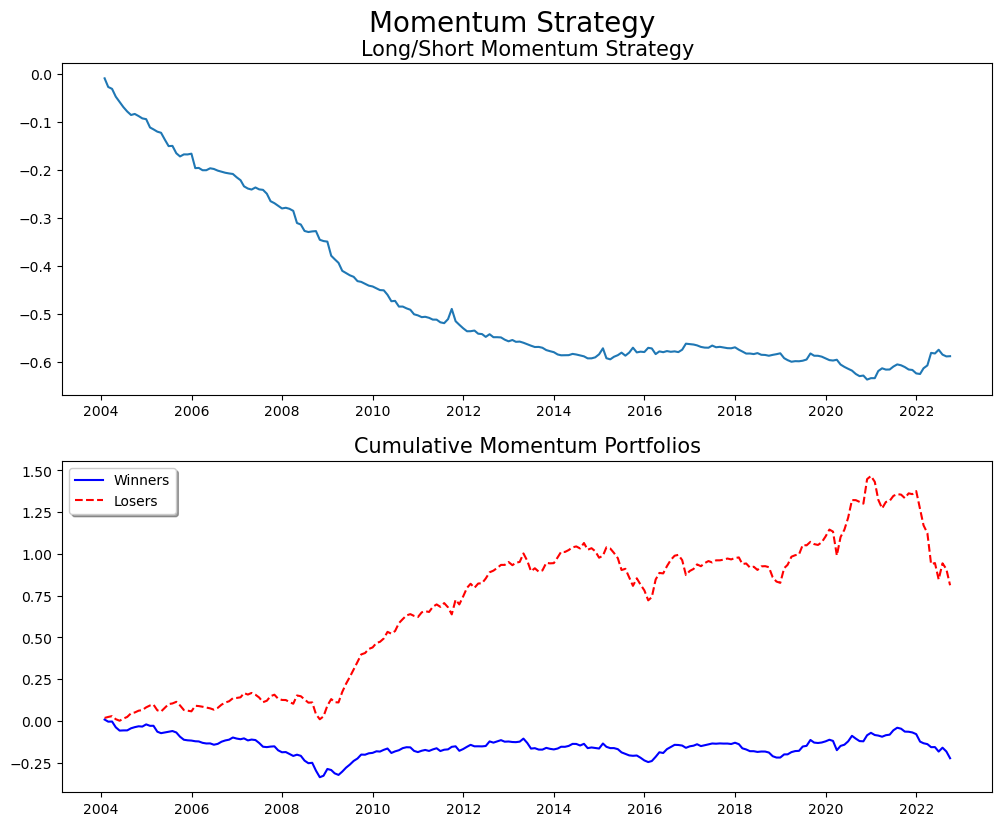

In [234]:
plt.figure(figsize=(12,9)) 
plt.suptitle('Momentum Strategy', fontsize=20) 

ax1 = plt.subplot(211) 
ax1.set_title('Long/Short Momentum Strategy', fontsize=15) 
ax1.plot(ewret_t['cumret_long_short']) 

ax2 = plt.subplot(212) 
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15) 
ax2.plot(ewret_t['cumret_winners'], 'b-', ewret_t['cumret_losers'], 'r--') 
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)